# Run limma differential expression analysis
Compare CTRL and ENDO cells using the genotype as a covariate

In [41]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

### Load raw counts

In [42]:
# anndata_sec <- readRDS('/nfs/team292/lg18/endometriosis/MiloR_objects/nuclei_epithelials_mockPROLIFERATIVE_integrated.rds')
# anndata_prolif <- readRDS('/nfs/team292/lg18/endometriosis/MiloR_objects/nuclei_epithelials_SECRETORY_integrated.rds')
# anndata <- merge(anndata_sec, y = anndata_prolif)
# anndata

In [43]:
anndata <- readRDS('/nfs/team292/lg18/endometriosis/SeuratR_objects/nuclei_mesenchymal.rds')
anndata

An object of class Seurat 
30595 features across 79479 samples within 1 assay 
Active assay: RNA (30595 features, 0 variable features)

In [44]:
anndata = subset(anndata,  celltype != c('Fibroblast_basalis') )

In [45]:
table(anndata$Group)


Ctrl_Superficial Endo_Superficial 
           20872            58533 

In [46]:
anndata$disease = gsub('_whole_uterus', '', anndata$Group)
anndata$disease = gsub('_Superficial', '', anndata$Group)
anndata$classification = paste(anndata$celltype, anndata$disease, sep='-') # split celltype by disease status
table(anndata$disease)
anndata


 Ctrl  Endo 
20872 58533 

An object of class Seurat 
30595 features across 79405 samples within 1 assay 
Active assay: RNA (30595 features, 0 variable features)

In [47]:
# estimate % cells expressing a gene in each class
plot <- DotPlot(object = anndata, features = rownames(anndata), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [48]:
anndata_sce <- as.SingleCellExperiment(anndata)

### Prepare the pseudobulk count matrix:

In [49]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste(colData(anndata_sce)$dataset, 
                                colData(anndata_sce)$disease, 
                                colData(anndata_sce)$celltype, 
                                colData(anndata_sce)$genotype, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])


##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$Group)

,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-1,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-10,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-2,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-3,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-4,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-5,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-6,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-7,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-8,Mareckova_Nuclei-Ctrl-dStromal_early-FX0011-9,⋯,Mareckova_Nuclei-Endo-eStromal-FX9020-9,Mareckova_Nuclei-Endo-eStromal-FX9022-1,Mareckova_Nuclei-Endo-eStromal-FX9022-2,Mareckova_Nuclei-Endo-eStromal-FX9022-3,Mareckova_Nuclei-Endo-eStromal-FX9022-4,Mareckova_Nuclei-Endo-eStromal-FX9022-5,Mareckova_Nuclei-Endo-eStromal-FX9022-6,Mareckova_Nuclei-Endo-eStromal-FX9022-7,Mareckova_Nuclei-Endo-eStromal-FX9022-8,Mareckova_Nuclei-Endo-eStromal-FX9022-9
A1BG,0,1,1,0,0,0,0,0,0,0,⋯,7,0,1,0,0,1,0,0,1,0
A1BG-AS1,0,0,1,1,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,2,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0



dStromal_early-Ctrl dStromal_early-Endo  dStromal_late-Ctrl  dStromal_late-Endo 
                 93                 285                  95                 282 
  dStromal_mid-Ctrl   dStromal_mid-Endo         ePV_1a-Ctrl         ePV_1a-Endo 
                 87                 294                  16                  44 
        ePV_1b-Ctrl         ePV_1b-Endo          ePV_2-Ctrl          ePV_2-Endo 
                 17                  48                  91                 249 
 eStromal_MMPs-Ctrl  eStromal_MMPs-Endo       eStromal-Ctrl       eStromal-Endo 
                 84                 257                 100                 302 


Ctrl_Superficial Endo_Superficial 
             583             1761 

In [81]:
percent_mat['IGF2',]
percent_mat['IGF1',]

dStromal_early-Ctrl dStromal_early-Endo  dStromal_late-Ctrl  dStromal_late-Endo 
           1.385542            2.331557            2.290076            5.958717 
  dStromal_mid-Ctrl   dStromal_mid-Endo         ePV_1a-Ctrl         ePV_1a-Endo 
           1.904762            2.928150            0.000000            1.587302 
        ePV_1b-Ctrl         ePV_1b-Endo          ePV_2-Ctrl          ePV_2-Endo 
           0.000000            0.000000            3.278689            2.011834 
 eStromal_MMPs-Ctrl  eStromal_MMPs-Endo       eStromal-Ctrl       eStromal-Endo 
          18.779790            8.025762            3.388927            2.144912

dStromal_early-Ctrl dStromal_early-Endo  dStromal_late-Ctrl  dStromal_late-Endo 
           96.14458            97.42101            85.95420            78.61872 
  dStromal_mid-Ctrl   dStromal_mid-Endo         ePV_1a-Ctrl         ePV_1a-Endo 
           88.40722            87.61073            89.47368            71.42857 
        ePV_1b-Ctrl         ePV_1b-Endo          ePV_2-Ctrl          ePV_2-Endo 
           65.00000            61.66667            79.50820            73.72781 
 eStromal_MMPs-Ctrl  eStromal_MMPs-Endo       eStromal-Ctrl       eStromal-Endo 
           56.86368            80.29890            96.71008            96.54198

## Run DEG per celltype

In [66]:
table(summed$celltype)
DEGs_list = list()


dStromal_early  dStromal_late   dStromal_mid         ePV_1a         ePV_1b 
           378            377            381             60             65 
         ePV_2       eStromal  eStromal_MMPs 
           340            402            341 

### Uncorrected

[1] "dStromal_early"
[1] "dStromal_late"


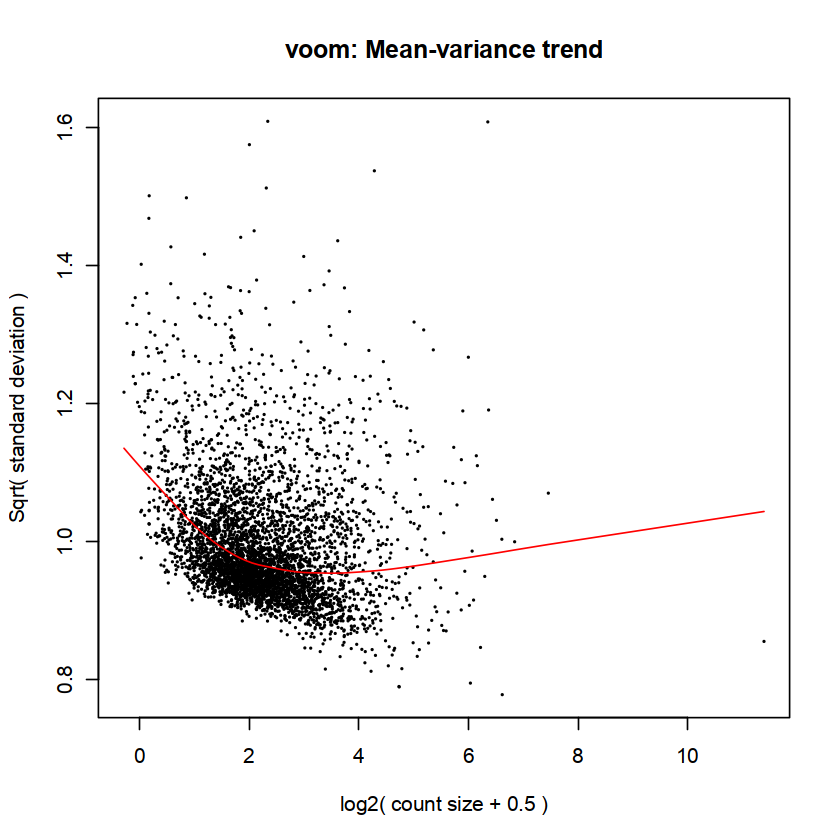

[1] "dStromal_mid"


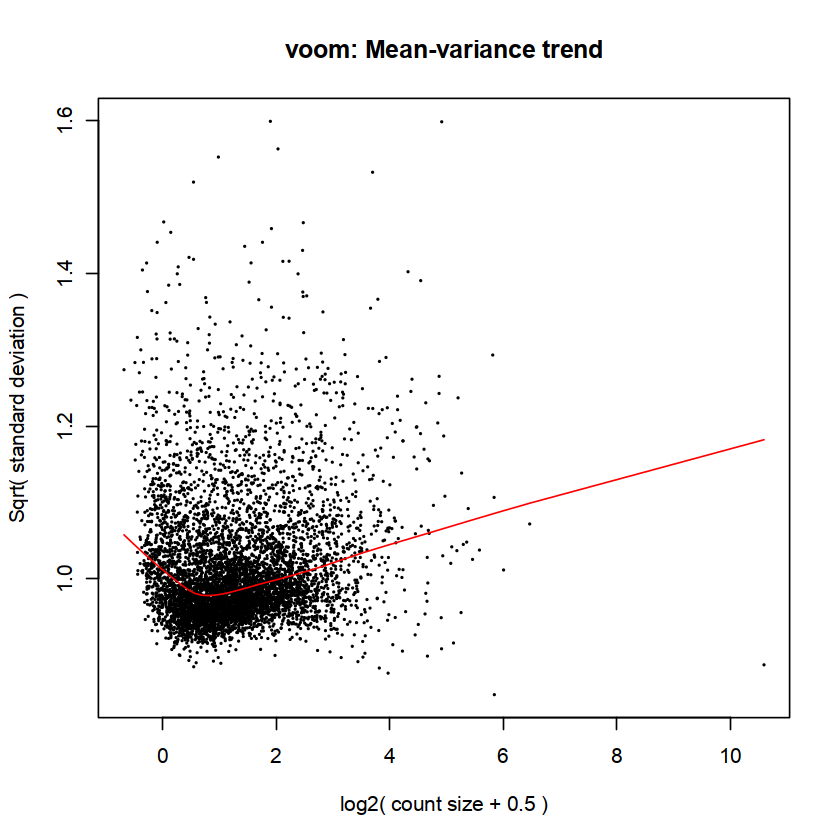

[1] "ePV_1a"


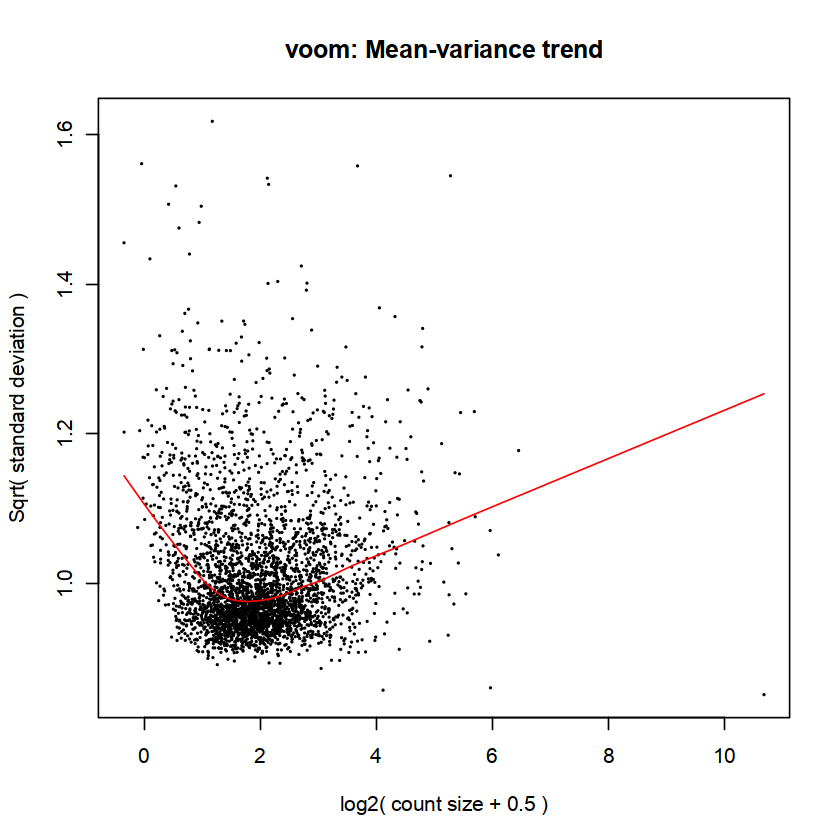

[1] "ePV_1b"


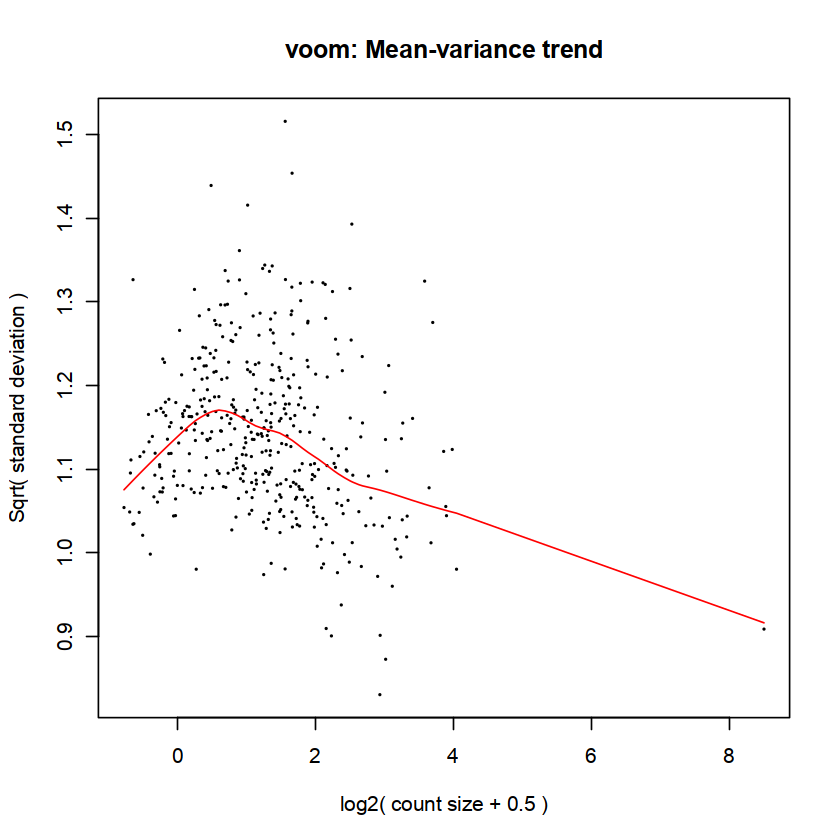

[1] "ePV_2"


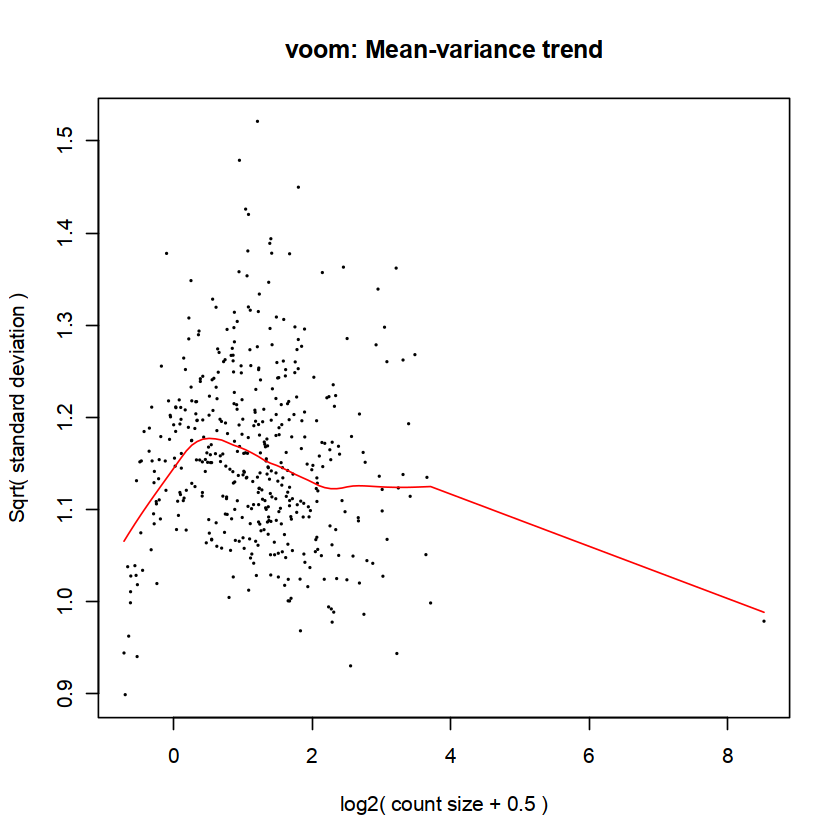

[1] "eStromal_MMPs"


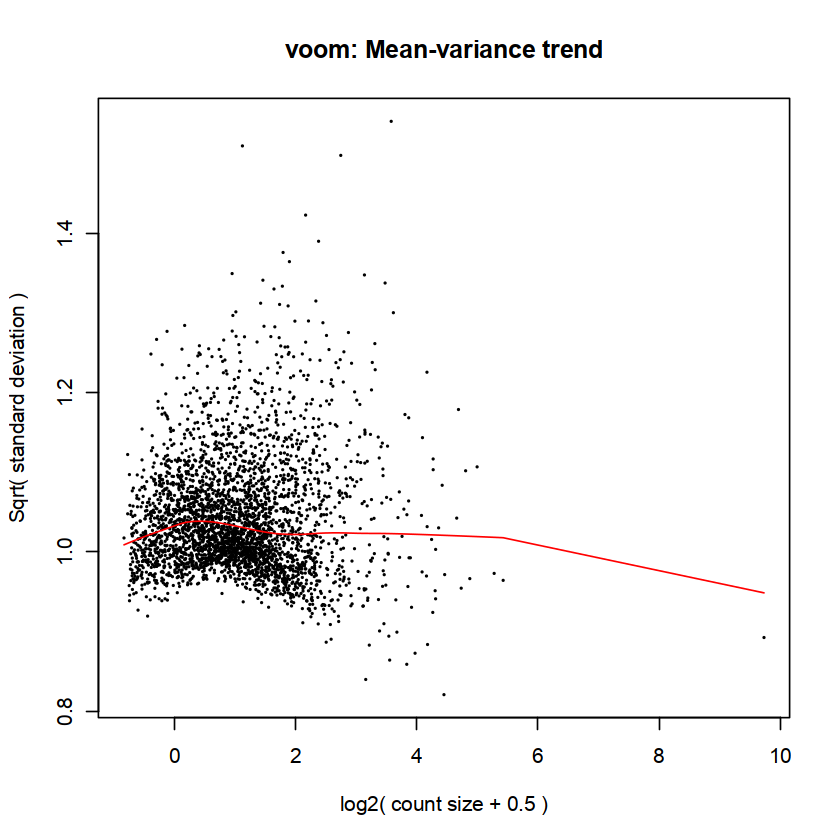

[1] "eStromal"


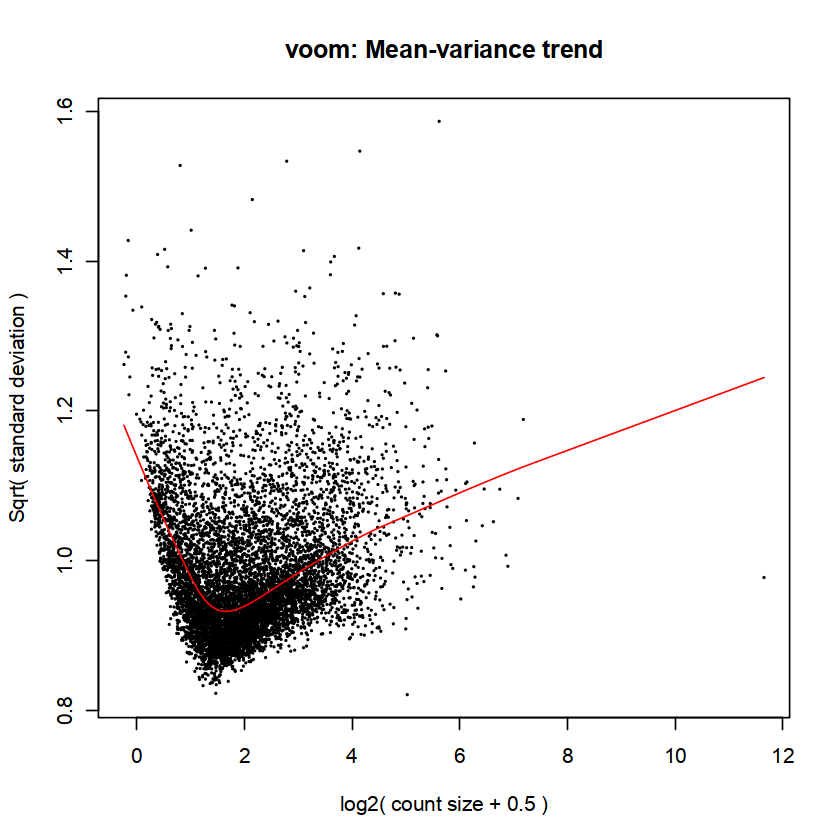

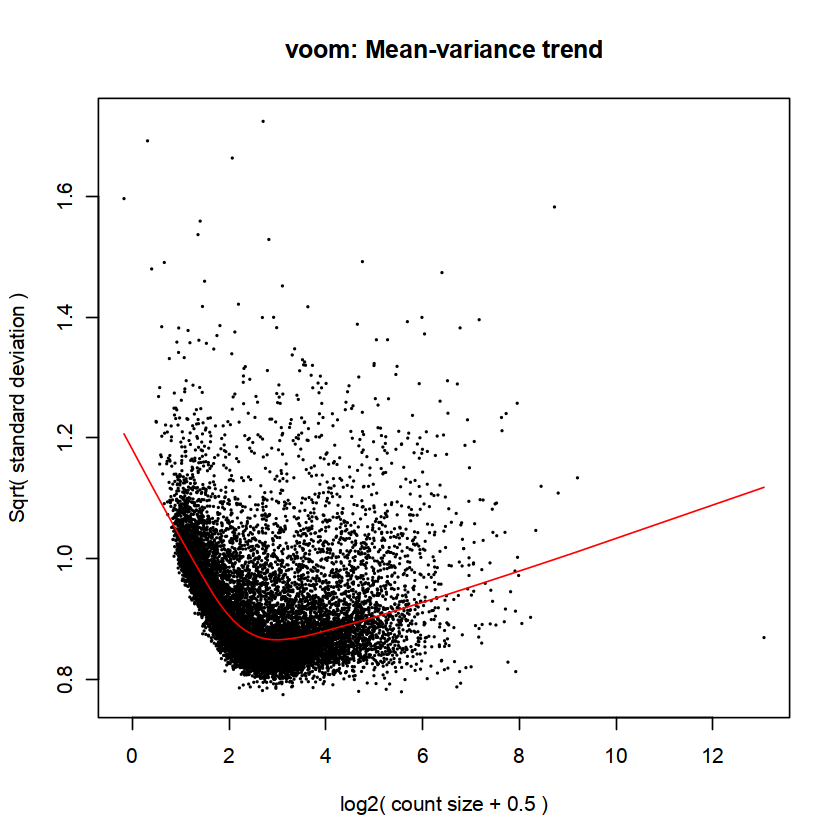

In [67]:
for (celltypeOf_interest in unique(summed$celltype) ){
#     celltypeOf_interest = 'dStromal_mid'
    print(celltypeOf_interest)
    
    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$celltype == celltypeOf_interest)

    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
#     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$genotype)
    genes10percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) >= 5 ] # get genes with > 10% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes10percent
    y <- y[ keep ,]

    ##see how many genes were kept 
    summary(keep)


    # (2) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    # Extract the dataset ID from the meta.data, then create the design matrix
    ## Create the design matrix and include the dataset as a covariate:
#     design <- model.matrix(~ 0 + summed_celltype$Group + summed_celltype$genotype)
    design <- model.matrix(~ 0 + summed_celltype$Group)
    # Have a look
    head(design)

    # change column/rownames names to more simple group names: 
    colnames(design) = gsub('summed_celltype\\$', '', colnames(design))
    colnames(design) = gsub('GroupEndo_Superficial', 'ENDOMETRIOSIS', colnames(design))
    colnames(design) = gsub('GroupCtrl_Superficial', 'CONTROL', colnames(design))
    colnames(design)
    rownames(design) <- colData(summed_celltype)$metacell_id

    # Have a look
    head(design)

    # (3) Specify which contrast to analyse:
    contrast.mat <- limma::makeContrasts(CONTROL-ENDOMETRIOSIS, levels = design) # positive values will mean upregulation in CONTROL

    # (4) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    dge <- edgeR::calcNormFactors(y)  

    # (5) Do limma DEG
    vm <- limma::voom(dge, design = design, plot = TRUE)
    fit <- limma::lmFit(vm, design = design)
    fit.contrasts <- limma::contrasts.fit(fit, contrast.mat)
    fit.contrasts <- limma::eBayes(fit.contrasts)

    # (6) We can use topTable to get the most significantly differentially expressed genes, and save the full DE results to an object. How many genes are significant? Are you suprised by this number?
    # Show the top differentially expressed genes:
    limma::topTable(fit.contrasts, sort.by = "P")
    limma_de <- limma::topTable(fit.contrasts, number = Inf, sort.by = "P")
    limma_de$Gene = rownames(limma_de)
    DEGs_list[[celltypeOf_interest]] = limma_de
    
}

# Save DEGs
limma_de = melt(DEGs_list, id.vars = names(DEGs_list[[1]]))
limma_de$meaning = ifelse(limma_de$logFC > 0, 'up_CONTROL', 'up_ENDOMETRIOSIS')
limma_de$meaning[ limma_de$adj.P.Val > 0.05 ] = 'not significant'
limma_de = limma_de[ order(limma_de$logFC, decreasing = T), ]
colnames(limma_de)[8] = 'celltype'
limma_de = limma_de[, c('celltype', 'Gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B', 'meaning') ]

write.table(limma_de, 
            file='/nfs/team292/lg18/endometriosis/DEGs_endometriosis/nuclei_mesenchymal_uncorrected.tsv', sep='\t', quote=F, row.names=F)

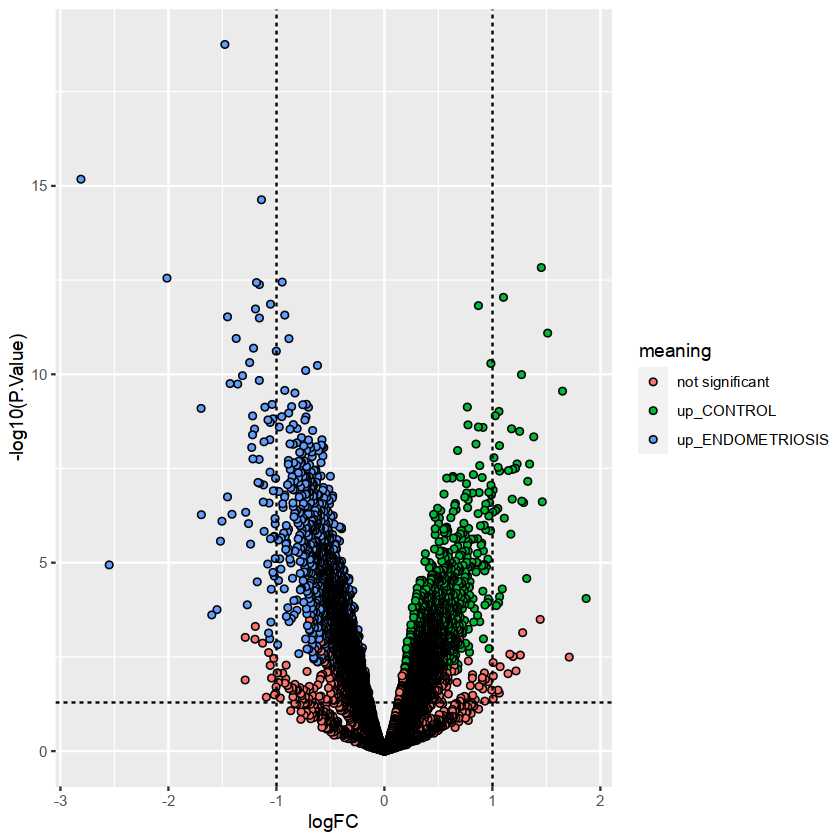

In [68]:
limma_de %>%
  ggplot(aes(x = logFC,
             y = -log10(P.Value),
             fill = meaning)) + 
  geom_point(shape = 21, colour = "black") +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed") + 
  geom_vline(xintercept = c(log2(0.5), log2(2)),
             linetype = "dashed")

### Corrected by genotype

[1] "dStromal_early"
Coefficients not estimable: genotypeFX1106 genotypeFX1141 genotypeFX1205 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 4488 probe(s)”


Coefficients not estimable: genotypeFX1106 genotypeFX1141 genotypeFX1205 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 4488 probe(s)”


[1] "dStromal_late"
Coefficients not estimable: genotypeFX1141 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 6165 probe(s)”


Coefficients not estimable: genotypeFX1141 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 6165 probe(s)”


[1] "dStromal_mid"
Coefficients not estimable: genotypeFX1141 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 3380 probe(s)”


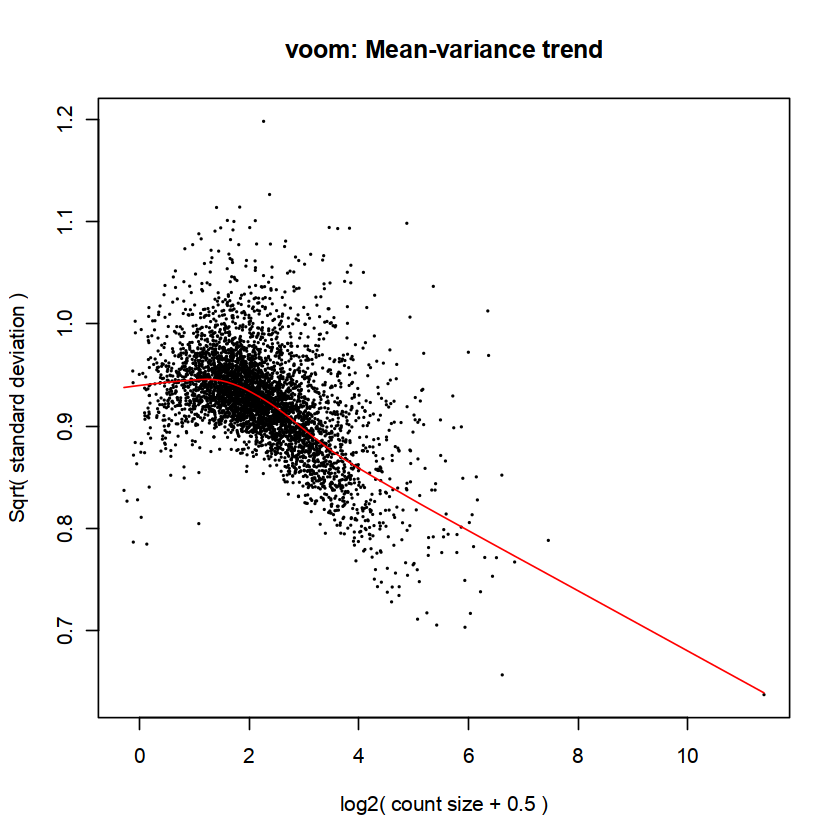

Coefficients not estimable: genotypeFX1141 genotypeFX1215 genotypeFX9027 


Warning message:
“Partial NA coefficients for 3380 probe(s)”


[1] "ePV_1a"
Coefficients not estimable: genotypeEX0277 genotypeEX0661 genotypeEX0789 genotypeEX0795 genotypeFX0022 genotypeFX0028 genotypeFX0052 genotypeFX1097 genotypeFX1106 genotypeFX1125 genotypeFX1129 genotypeFX1136 genotypeFX1141 genotypeFX1156 genotypeFX1158 genotypeFX1160 genotypeFX1205 genotypeFX1215 genotypeFX1233 genotypeFX9009 genotypeFX9027 


Warning message:
“Partial NA coefficients for 415 probe(s)”


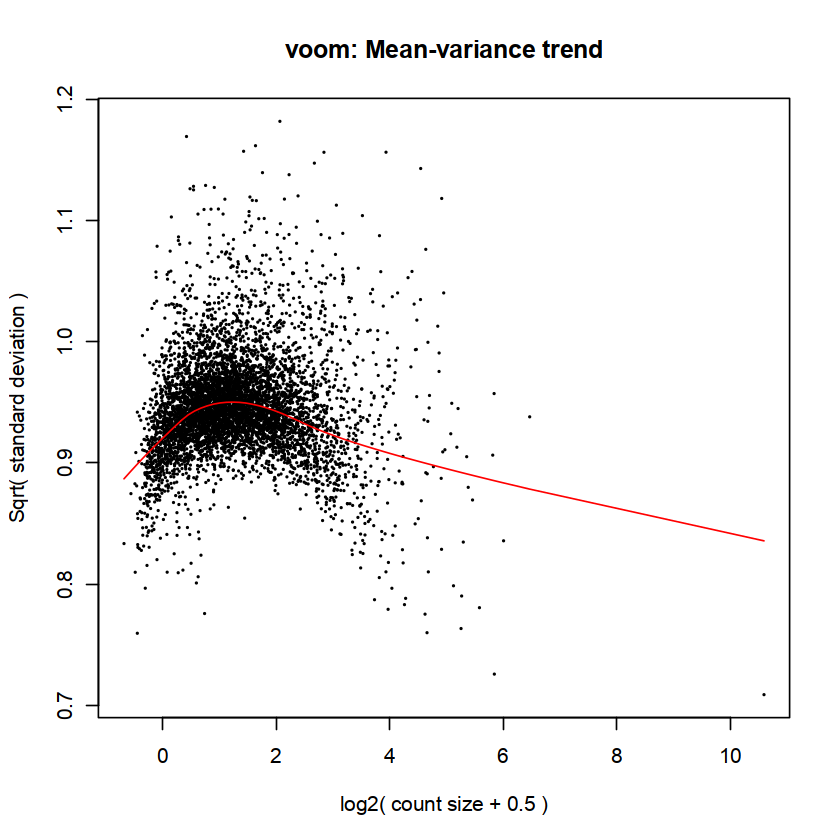

Coefficients not estimable: genotypeEX0277 genotypeEX0661 genotypeEX0789 genotypeEX0795 genotypeFX0022 genotypeFX0028 genotypeFX0052 genotypeFX1097 genotypeFX1106 genotypeFX1125 genotypeFX1129 genotypeFX1136 genotypeFX1141 genotypeFX1156 genotypeFX1158 genotypeFX1160 genotypeFX1205 genotypeFX1215 genotypeFX1233 genotypeFX9009 genotypeFX9027 


Warning message:
“Partial NA coefficients for 415 probe(s)”


[1] "ePV_1b"
Coefficients not estimable: genotypeEX0277 genotypeEX0795 genotypeFX0060 genotypeFX1097 genotypeFX1106 genotypeFX1119 genotypeFX1125 genotypeFX1129 genotypeFX1130 genotypeFX1136 genotypeFX1141 genotypeFX1158 genotypeFX1160 genotypeFX1163 genotypeFX1170 genotypeFX1205 genotypeFX1215 genotypeFX1223 genotypeFX1233 genotypeFX9005 genotypeFX9008 genotypeFX9020 genotypeFX9024 genotypeFX9027 


Warning message:
“Partial NA coefficients for 437 probe(s)”


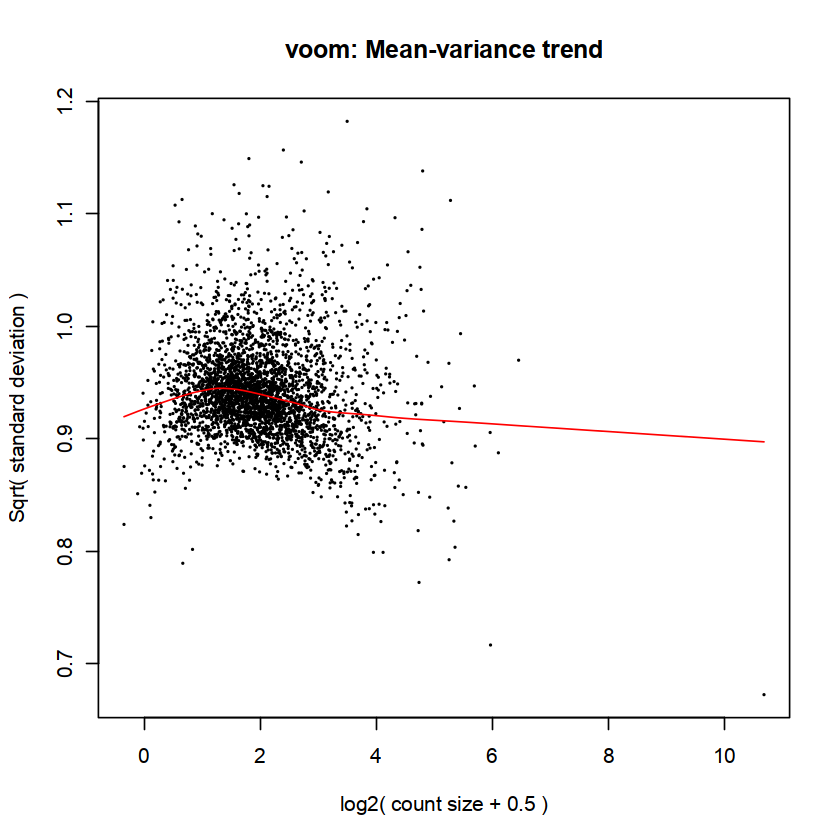

Coefficients not estimable: genotypeEX0277 genotypeEX0795 genotypeFX0060 genotypeFX1097 genotypeFX1106 genotypeFX1119 genotypeFX1125 genotypeFX1129 genotypeFX1130 genotypeFX1136 genotypeFX1141 genotypeFX1158 genotypeFX1160 genotypeFX1163 genotypeFX1170 genotypeFX1205 genotypeFX1215 genotypeFX1223 genotypeFX1233 genotypeFX9005 genotypeFX9008 genotypeFX9020 genotypeFX9024 genotypeFX9027 


Warning message:
“Partial NA coefficients for 437 probe(s)”


[1] "ePV_2"
Coefficients not estimable: genotypeFX1141 genotypeFX9027 


Warning message:
“Partial NA coefficients for 3313 probe(s)”


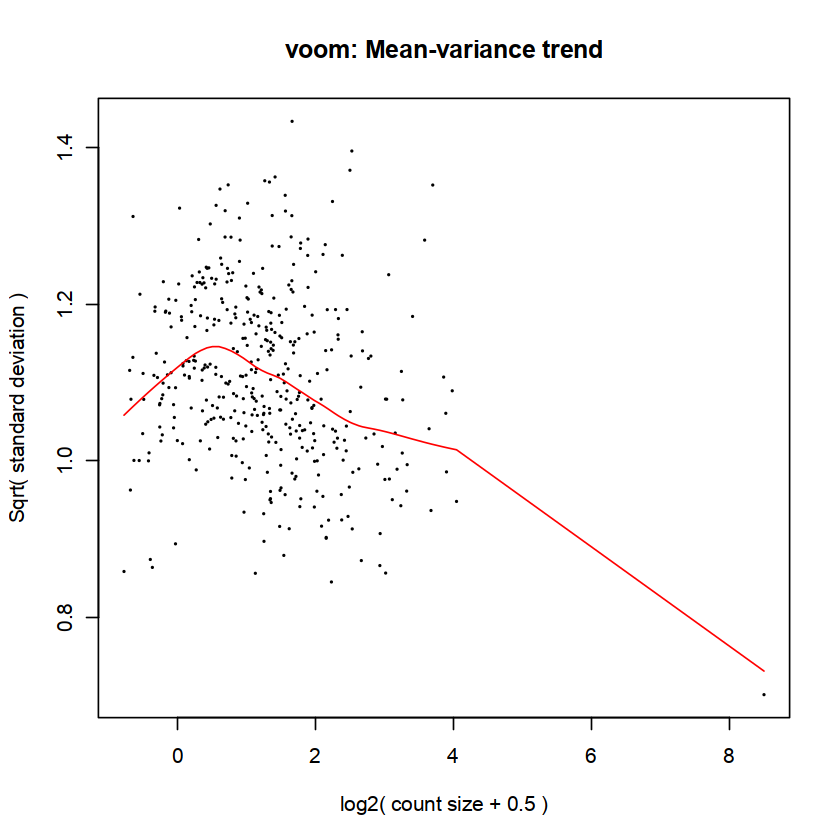

Coefficients not estimable: genotypeFX1141 genotypeFX9027 


Warning message:
“Partial NA coefficients for 3313 probe(s)”


[1] "eStromal_MMPs"
Coefficients not estimable: genotypeFX1215 genotypeFX9008 genotypeFX9027 


Warning message:
“Partial NA coefficients for 7893 probe(s)”


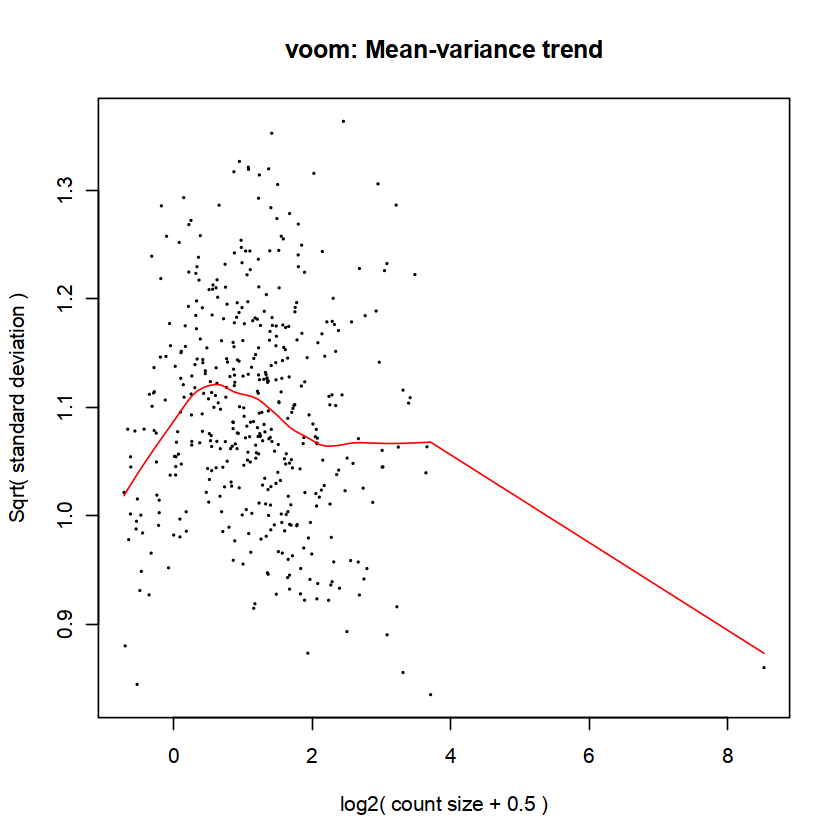

Coefficients not estimable: genotypeFX1215 genotypeFX9008 genotypeFX9027 


Warning message:
“Partial NA coefficients for 7893 probe(s)”


[1] "eStromal"
Coefficients not estimable: genotypeFX1106 genotypeFX1215 genotypeFX9009 genotypeFX9027 


Warning message:
“Partial NA coefficients for 12328 probe(s)”


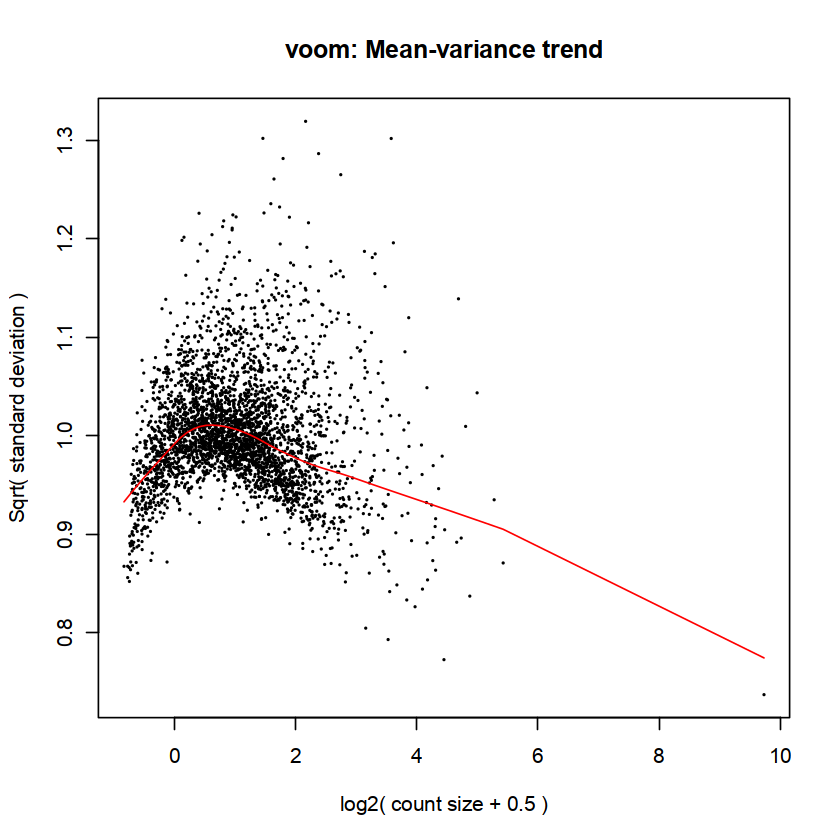

Coefficients not estimable: genotypeFX1106 genotypeFX1215 genotypeFX9009 genotypeFX9027 


Warning message:
“Partial NA coefficients for 12328 probe(s)”


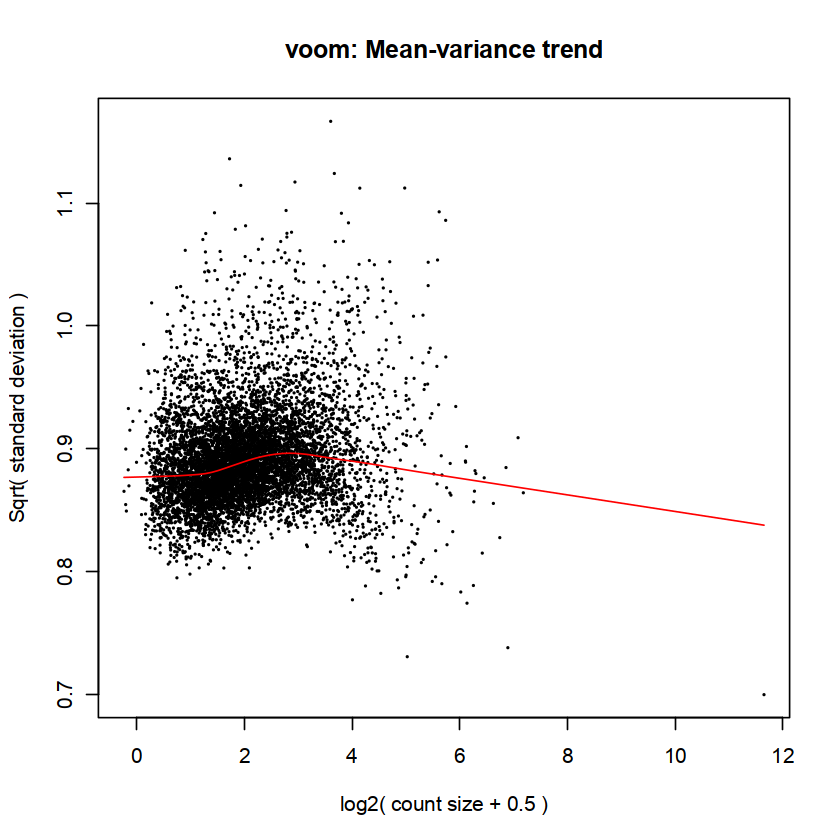

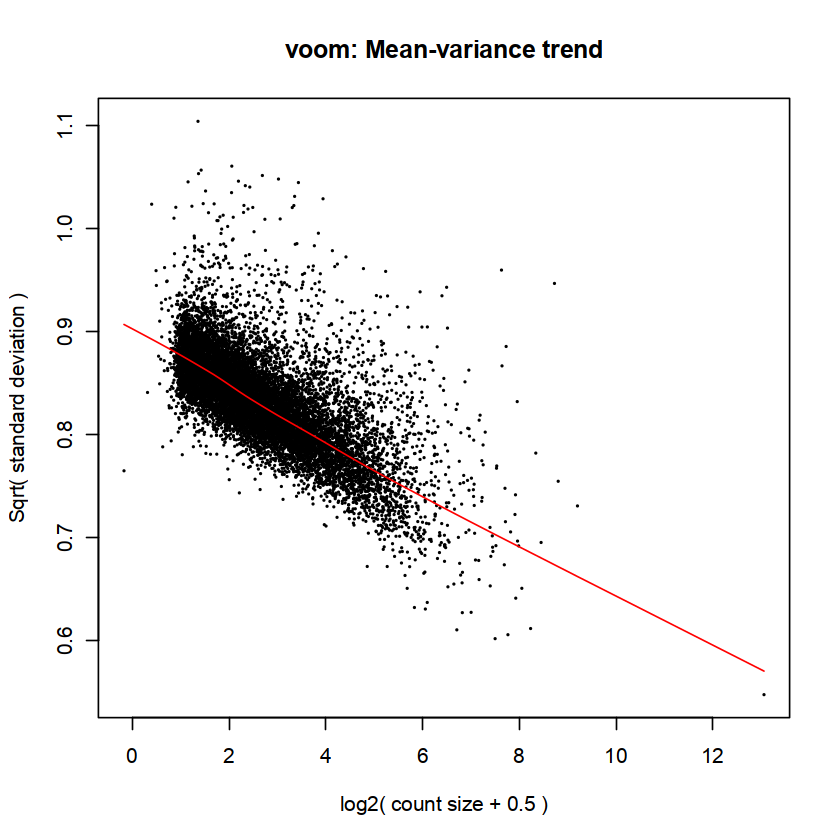

In [69]:
for (celltypeOf_interest in unique(summed$celltype) ){
#     celltypeOf_interest = 'dStromal_mid'
    print(celltypeOf_interest)
    
    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$celltype == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
#     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$genotype)
    genes10percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) >= 5 ] # get genes with > 10% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes10percent
    y <- y[ keep ,]

    ##see how many genes were kept 
    summary(keep)


    # (2) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    # Extract the dataset ID from the meta.data, then create the design matrix
    ## Create the design matrix and include the dataset as a covariate:
    design <- model.matrix(~ 0 + summed_celltype$Group + summed_celltype$genotype)
#     design <- model.matrix(~ 0 + summed_celltype$Group)
    # Have a look
    head(design)

    # change column/rownames names to more simple group names: 
    colnames(design) = gsub('summed_celltype\\$', '', colnames(design))
    colnames(design) = gsub('GroupEndo_Superficial', 'ENDOMETRIOSIS', colnames(design))
    colnames(design) = gsub('GroupCtrl_Superficial', 'CONTROL', colnames(design))
    colnames(design)
    rownames(design) <- colData(summed_celltype)$metacell_id

    # Have a look
    head(design)

    # (3) Specify which contrast to analyse:
    contrast.mat <- limma::makeContrasts(CONTROL-ENDOMETRIOSIS, levels = design) # positive values will mean upregulation in CONTROL

    # (4) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    dge <- edgeR::calcNormFactors(y)  

    # (5) Do limma DEG
    vm <- limma::voom(dge, design = design, plot = TRUE)
    fit <- limma::lmFit(vm, design = design)
    fit.contrasts <- limma::contrasts.fit(fit, contrast.mat)
    fit.contrasts <- limma::eBayes(fit.contrasts)

    # (6) We can use topTable to get the most significantly differentially expressed genes, and save the full DE results to an object. How many genes are significant? Are you suprised by this number?
    # Show the top differentially expressed genes:
    limma::topTable(fit.contrasts, sort.by = "P")
    limma_de <- limma::topTable(fit.contrasts, number = Inf, sort.by = "P")
    limma_de$Gene = rownames(limma_de)
    DEGs_list[[celltypeOf_interest]] = limma_de
    
}

# Save DEGs
limma_de = melt(DEGs_list, id.vars = names(DEGs_list[[1]]))
limma_de$meaning = ifelse(limma_de$logFC > 0, 'up_CONTROL', 'up_ENDOMETRIOSIS')
limma_de = limma_de[ order(limma_de$logFC, decreasing = T), ]
limma_de$meaning[ limma_de$adj.P.Val > 0.05 ] = 'not significant'
colnames(limma_de)[8] = 'celltype'
limma_de = limma_de[, c('celltype', 'Gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B', 'meaning') ]

write.table(limma_de, 
            file='/nfs/team292/lg18/endometriosis/DEGs_endometriosis/nuclei_mesenchymal_corrected.tsv', sep='\t', quote=F, row.names=F)


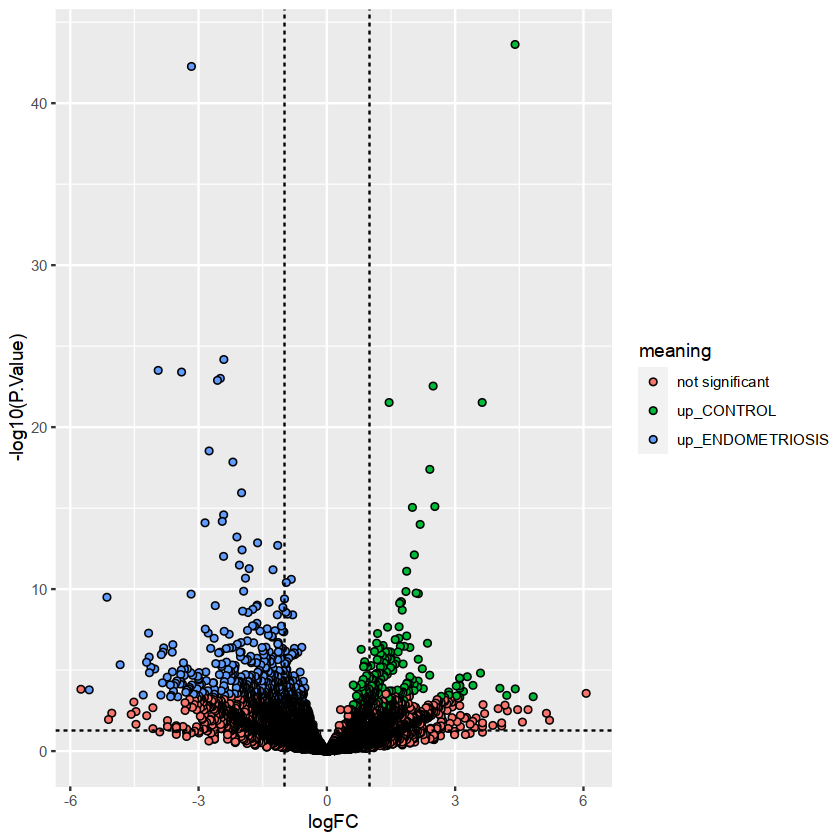

In [70]:
limma_de %>%
  ggplot(aes(x = logFC,
             y = -log10(P.Value),
             fill = meaning)) + 
  geom_point(shape = 21, colour = "black") +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed") + 
  geom_vline(xintercept = c(log2(0.5), log2(2)),
             linetype = "dashed")

## Explore results

In [71]:
head(subset(limma_de, adj.P.Val < 0.05), n = 20)
tail(subset(limma_de, adj.P.Val < 0.05), n = 20)

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
14453,ePV_1b,WWOX,4.824802,9.356811,3.695443,4.401261e-04,3.846702e-02,-0.09904151,up_CONTROL
14449,ePV_1b,NR2F2-AS1,4.405353,9.714621,4.026007,1.453596e-04,3.010623e-02,0.84791558,up_CONTROL
26092,eStromal,AC119673.2,4.400928,4.895607,15.805919,2.364661e-44,2.915154e-40,87.71468203,up_CONTROL
14452,ePV_1b,FAM155A,4.206665,8.958608,3.753491,3.636759e-04,3.846702e-02,0.06105262,up_CONTROL
18245,eStromal_MMPs,KCNC2,4.045673,5.988922,3.861513,1.324309e-04,2.223993e-02,0.88456538,up_CONTROL
26100,eStromal,LINC02507,3.631791,3.889245,10.286507,3.005017e-22,3.719593e-19,38.93596907,up_CONTROL
18217,eStromal_MMPs,NEK5,3.592904,4.705131,4.381265,1.528481e-05,6.349634e-03,2.79363488,up_CONTROL
18239,eStromal_MMPs,TG,3.416730,4.776485,3.965766,8.743953e-05,1.683318e-02,1.25047863,up_CONTROL
18222,eStromal_MMPs,POLR3H,3.283626,4.995020,4.261172,2.567693e-05,8.444499e-03,2.33621321,up_CONTROL


,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
18265,eStromal_MMPs,SYT1,-3.637365,8.834790,-3.592514,3.705589e-04,4.365405e-02,-0.01749520,up_ENDOMETRIOSIS
18271,eStromal_MMPs,ADAM12,-3.653364,8.516911,-3.545760,4.403728e-04,4.761456e-02,-0.16826372,up_ENDOMETRIOSIS
18236,eStromal_MMPs,PRDM1,-3.660378,9.218931,-3.983122,8.152878e-05,1.671275e-02,1.31329155,up_ENDOMETRIOSIS
18223,eStromal_MMPs,JAZF1,-3.732875,9.254234,-4.247593,2.720770e-05,8.590016e-03,2.28549687,up_ENDOMETRIOSIS
18202,eStromal_MMPs,PARD3,-3.815076,9.442200,-5.147817,4.237589e-07,8.361823e-04,6.00983532,up_ENDOMETRIOSIS
18203,eStromal_MMPs,ZNF516,-3.830340,9.671543,-5.025056,7.764863e-07,1.029125e-03,5.46519601,up_ENDOMETRIOSIS
18230,eStromal_MMPs,ZFPM2-AS1,-3.843740,8.777687,-4.054685,6.092982e-05,1.502872e-02,1.57076663,up_ENDOMETRIOSIS
18205,eStromal_MMPs,HMGB1,-3.871344,8.846041,-4.950093,1.117417e-06,1.259967e-03,5.13825105,up_ENDOMETRIOSIS
18264,eStromal_MMPs,LSAMP,-3.880389,9.633847,-3.607702,3.502133e-04,4.188233e-02,0.03183162,up_ENDOMETRIOSIS


### Plot genes of interest

In [72]:
genes = c('DKK1', 
          'IGF1', 'IGF2',  'IGFBP1', 'IGFBP3', 'IGF1R', 'INSR',  'IRS2', 'TMEM219',
          'GDF7',  'LEFTY2', 'LEFTY1', 'BMP2',
          'CALB2', 'GREB1'
         )
significant_limma_de = subset(limma_de, Gene %in% genes & abs(logFC) > 0.5)
significant_limma_de
significant_genes = limma_de$Gene

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4991,dStromal_late,IGFBP3,1.1830916,6.902126,2.1278110,3.393270e-02,0.4158948387,-3.8390755,not significant
15017,ePV_2,IGFBP1,0.9875755,5.664758,2.7275563,6.710536e-03,0.1669707125,-2.5031858,not significant
20145,eStromal_MMPs,LEFTY2,0.9616976,4.794372,1.2136194,2.256472e-01,0.9144726599,-5.2650201,not significant
20503,eStromal_MMPs,IGFBP1,0.9616976,5.025343,1.0889664,2.768591e-01,0.9455343259,-5.3988941,not significant
301,dStromal_early,IGFBP1,0.9480540,4.630627,2.7711826,5.849918e-03,0.0870484370,-2.4432198,not significant
604,dStromal_early,DKK1,0.9480540,4.596720,2.2152217,2.731595e-02,0.2023132459,-3.7343216,not significant
548,dStromal_early,LEFTY2,0.7883686,4.384341,2.2991265,2.202010e-02,0.1803398068,-3.5572474,not significant
999,dStromal_early,IRS2,0.7883686,5.428785,1.7999102,7.263949e-02,0.3263323608,-4.5153719,not significant
21158,eStromal_MMPs,IRS2,0.7856271,5.732787,0.9267550,3.546422e-01,0.9455595147,-5.5515300,not significant


In [73]:
gwas_genes1 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/loci_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]
gwas_genes2 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/credible_sets_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]
gwas_genes3 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/metaregression_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]

endo_genes = c(gwas_genes1, gwas_genes2, gwas_genes3)
subset(limma_de, Gene %in% endo_genes & adj.P.Val < 0.05)
significant_genes = subset(limma_de, Gene %in% endo_genes & adj.P.Val < 0.05)$Gene
significant_genes

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
26171,eStromal,ABO,1.7186897,3.902650,5.181048,3.456710e-07,5.326791e-05,6.2931278,up_CONTROL
26268,eStromal,FN1,-0.9476996,7.723716,-4.255263,2.585723e-05,1.800949e-03,2.1448495,up_ENDOMETRIOSIS
15,dStromal_early,IGF1,-1.7689578,10.080687,-4.750611,2.845421e-06,8.513501e-04,4.3441708,up_ENDOMETRIOSIS
4526,dStromal_late,VEZT,-1.8844064,7.534308,-3.814124,1.571004e-04,2.548748e-02,0.7322255,up_ENDOMETRIOSIS
4523,dStromal_late,IGF1,-2.3904745,9.716652,-3.849987,1.364581e-04,2.339527e-02,0.8550945,up_ENDOMETRIOSIS


[1] "ABO"  "FN1"  "IGF1" "VEZT" "IGF1"

In [74]:
genes = c('TYRO3', 'IGF2', 'HES1')
subset(limma_de, Gene %in% genes)

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
20898,eStromal_MMPs,HES1,0.7856271,5.030885,0.9804694,3.274785e-01,0.9455343259,-5.503691,not significant
30439,eStromal,HES1,0.3187449,3.788185,1.0893621,2.766291e-01,0.7842826002,-5.708262,not significant
8812,dStromal_late,TYRO3,-0.2282966,5.559738,-0.4291081,6.680639e-01,0.9513561821,-5.905312,not significant
23828,eStromal_MMPs,TYRO3,-0.3003633,5.502276,-0.3759102,7.071935e-01,0.9821303679,-5.886857,not significant
26209,eStromal,TYRO3,-1.2998153,5.009539,-4.8159716,2.059332e-06,0.0002151479,4.611259,up_ENDOMETRIOSIS


## Visualise data as dotplot in summed dataset

In [75]:
summed_celltype <- logNormCounts(summed_celltype)

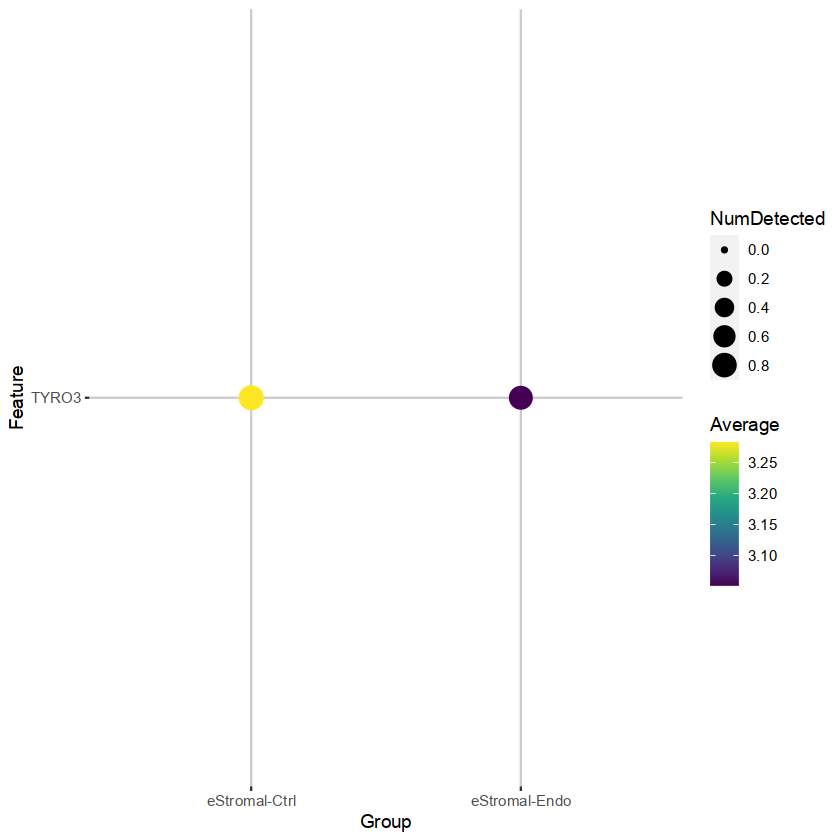

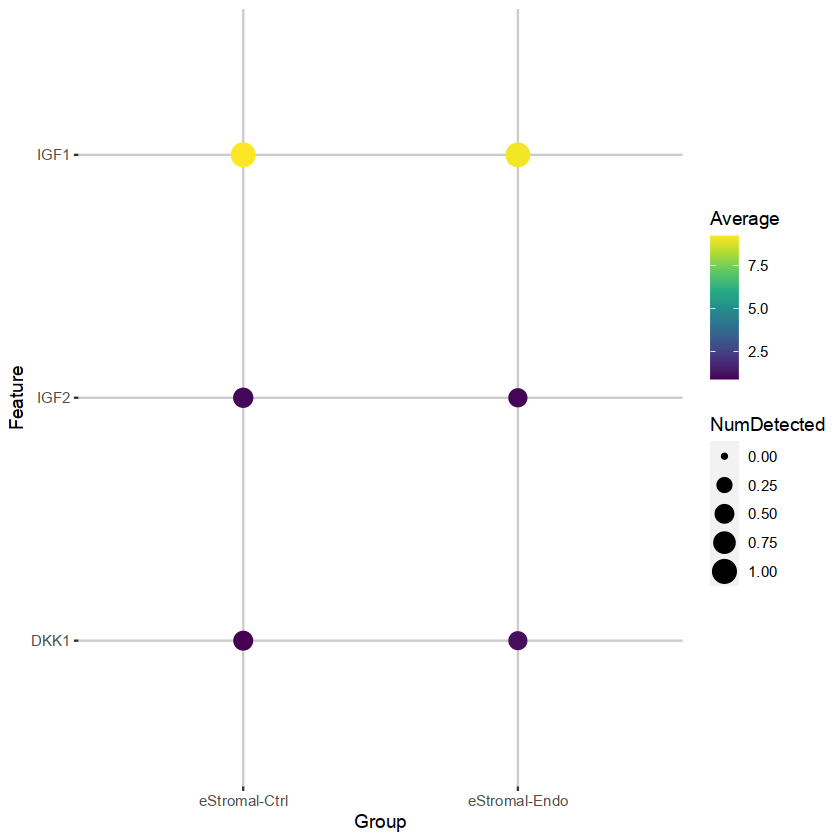

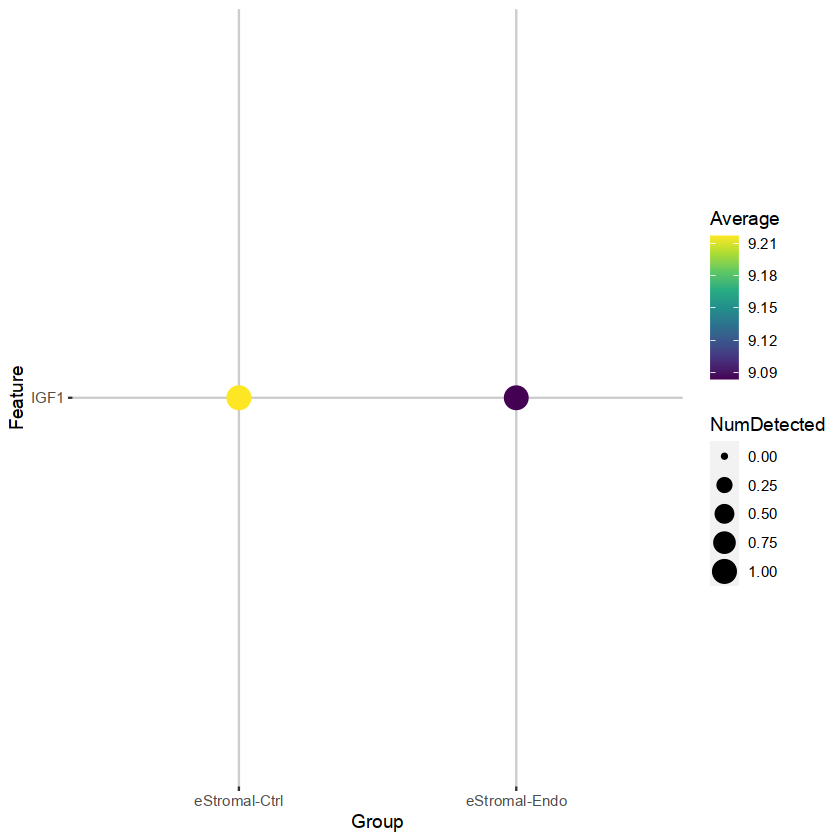

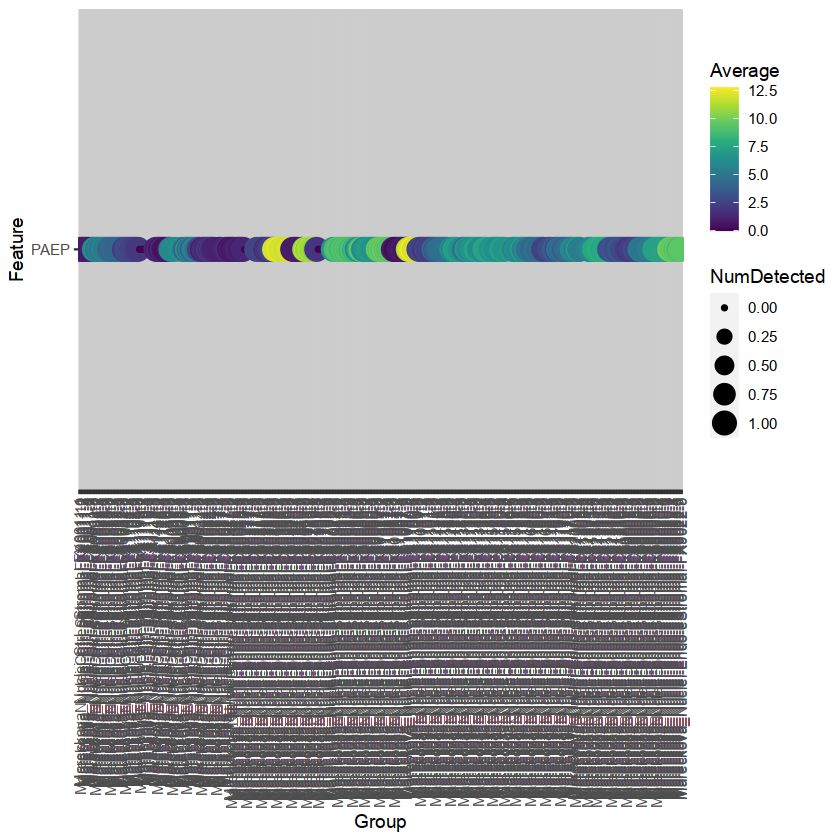

In [76]:
plotDots(summed_celltype, features=c('TYRO3'), group="classification")
plotDots(summed_celltype, features=c('DKK1', 'IGF2', 'IGF1'), group="classification")
plotDots(summed_celltype, features=c('IGF1'), group="classification")
plotDots(summed_celltype, features=c('PAEP'), group="metacell_id") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


## Visualise data as dotplot in original sc dataset

In [77]:
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Centering and scaling data matrix



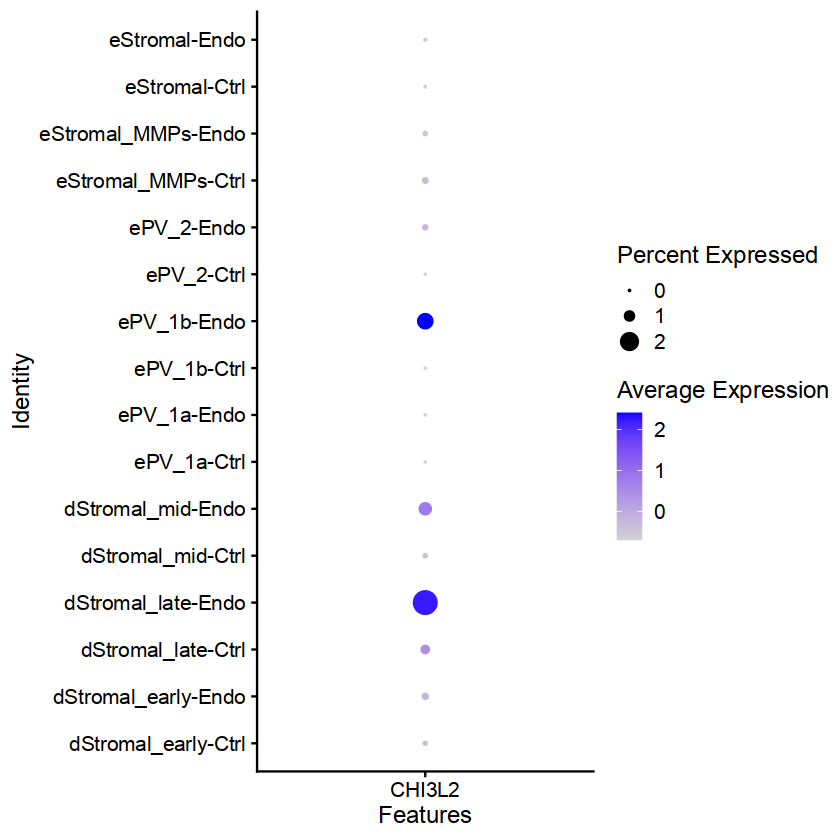

In [78]:
Seurat::DotPlot(anndata, features = c('CHI3L2'), group.by = 'classification')

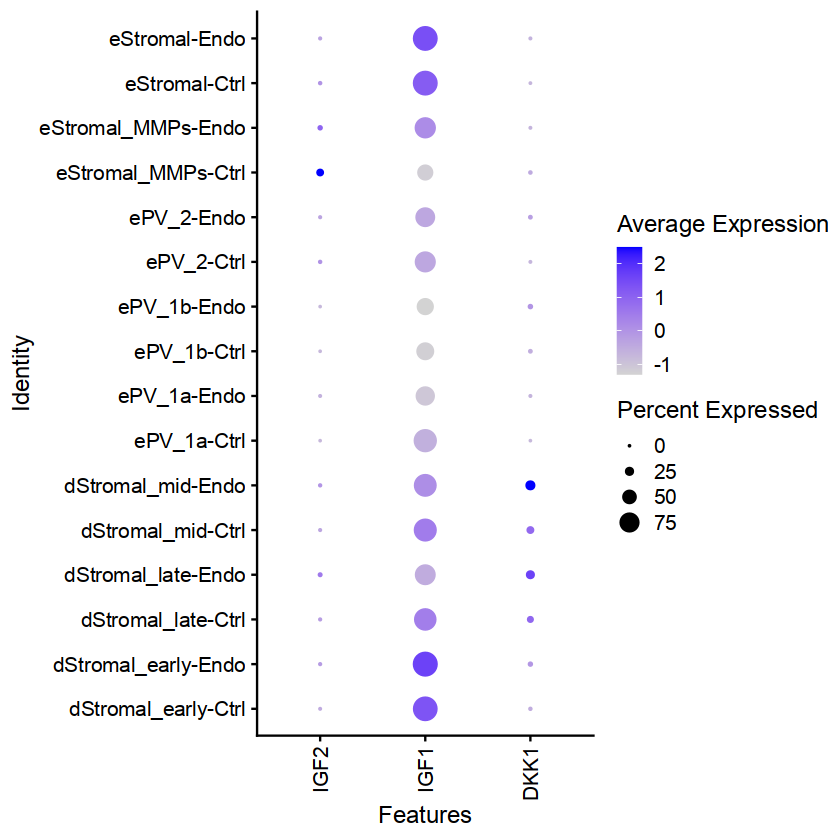

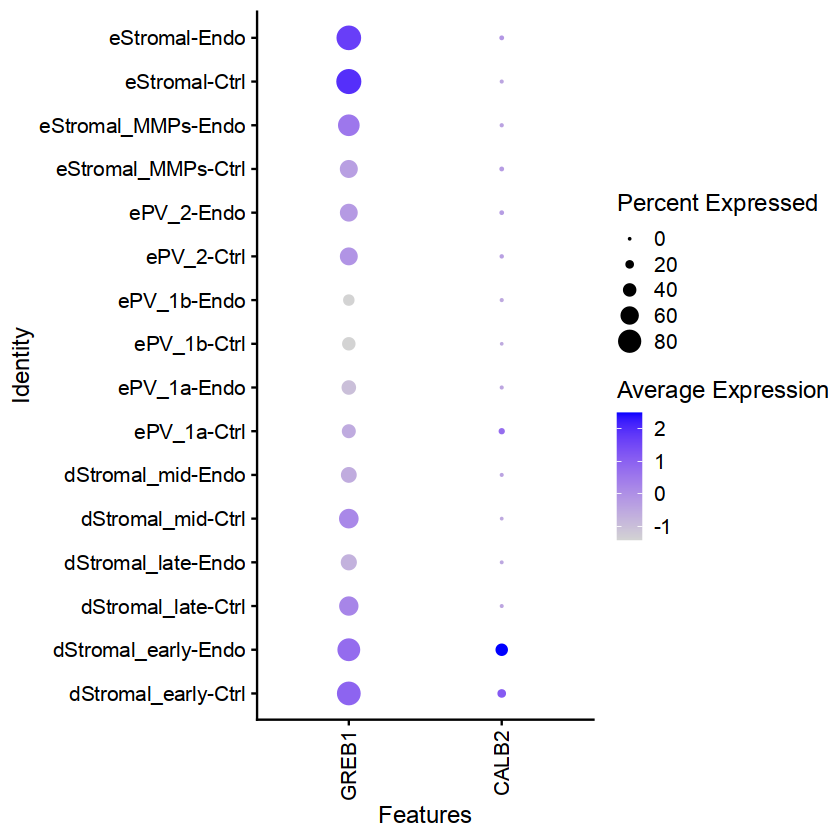

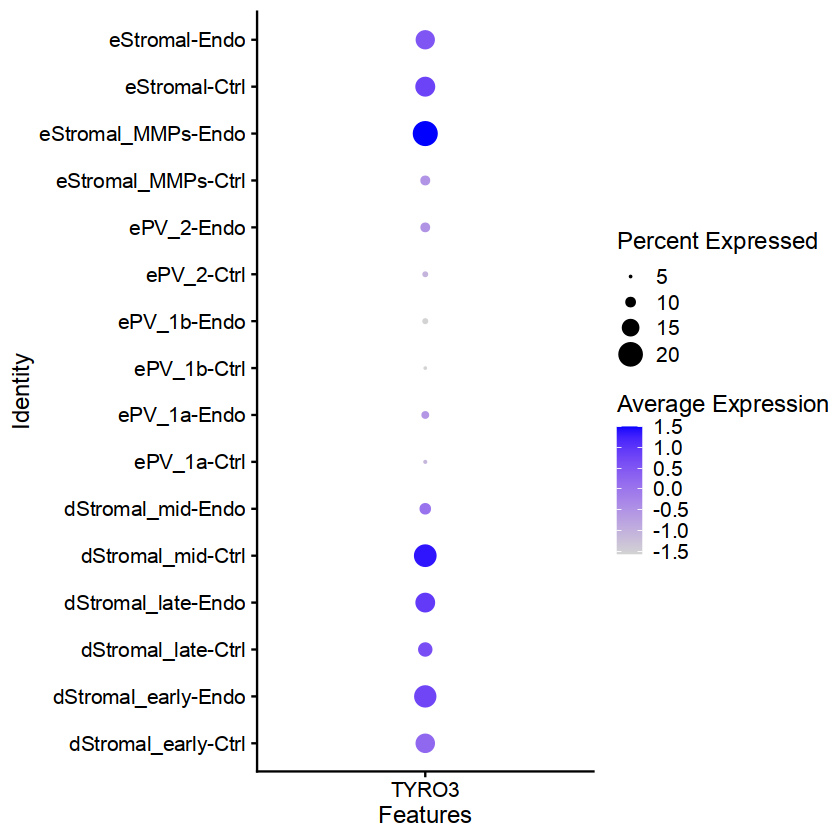

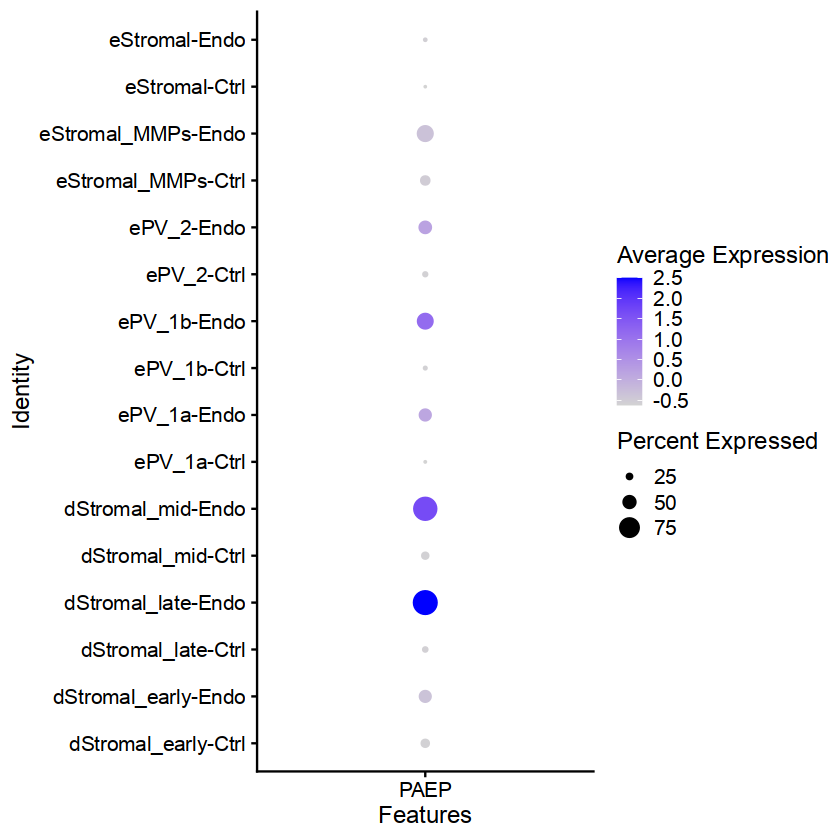

In [79]:
Seurat::DotPlot(anndata, features = c('IGF2', 'IGF1', 'DKK1'), group.by = 'classification')  + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
Seurat::DotPlot(anndata, features = c('GREB1', 'CALB2'), group.by = 'classification')  + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
Seurat::DotPlot(anndata, features = c('TYRO3'), group.by = 'classification')
Seurat::DotPlot(anndata, features = c('PAEP'), group.by = 'classification')

In [80]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/miloR-env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.40.2                SeuratObject_4.1.3         
 [5] Seurat_4.3.0                patchwork_1.1.2            
 [7] dplyr_1.1.2                 scran_1.26.2               
 [9] scater_1.26.1               ggplot2_3.4.2          